# Import packages

In [107]:
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx 
from collections import Counter
from fa2 import ForceAtlas2
from Functions import DataCollection, DataCleaning, GetRatings, GetConnectedMoviesArtist, Plots
from imdb import IMDb
import community.community_louvain as cl
import community
import numpy as np 
import heapq
from tabulate import tabulate

# Colors 

In [147]:
color_palette_cividis = sns.color_palette("cividis", 40)
color_palette_plasma = sns.color_palette("plasma", 40)
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
colorpalette = color_palette_plasma + color_palette_cividis_reversed
two_colors = colorpalette[::8][0:2]
three_ratings_colors = colorpalette[::6][0:3]
three_different_colors = colorpalette[::10][0:3]
genre_colors = colorpalette[::7][0:8]
# plt.figure(figsize = (20,2))
# plt.imshow([genre_colors])
# plt.axis('off')
# plt.show()

# Data Collection 

In [4]:
# params = {
#         "thriller": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],[[]]]}, 
#         "action": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]},             
#         "comedy": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007"]]},
#         "adventure": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022", "2023"], ["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"], ["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]}, 
#         "horror": {"years": ["2020", "2021", "2022", "2010","2011","2012","2013","2014","2015","2016","2017","2018","2019", "2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"], 
#                 "sub_years": [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]},
#         "fantasy": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [[[]],[[]],[[]]]}, 
#         "science_fiction": {"years": ["2020s", "2010s", "2000s"],
#                 "sub_years": [[[]],[[]],[[]]]}, 
#         }

# data_collection = DataCollection()
# data_movie_artist = pd.DataFrame()
# for genre in params.keys():
#     for years, sub_years in zip(params[genre]["years"],params[genre]["sub_years"]):
#         data = data_collection.collect_movies_artist_data(genre, years, sub_years)
#         data_movie_artist = pd.concat([data_movie_artist, data]) 

# data_movie_artist = data_movie_artist.reset_index(drop=True)

In [3]:
data_movie_artist = pd.read_json('data_movie_artist.json', orient='table')
data_movie_artist.shape

(7456, 7)

# Data Cleaning

In [6]:
# data_cleaner = DataCleaning(data_movie_artist)
# data_cleaner.data_cleaning()
# df_movies = data_cleaner.data

In [4]:
df_movies = pd.read_json('df_movies.json', orient='table')
df_movies.shape

(5778, 8)

# Get Ratings

In [346]:
# # Initialize the IMDb object
# ia = IMDb()

# # Function to get movie rating
# def get_movie_rating(title):
#     try:
#         movie = ia.search_movie(title)[0]  # Assume the first search result is the correct movie
#         ia.update(movie)
#         return movie.data['rating']
#     except Exception as e:
#         return None

# # Add a new column to the DataFrame with the ratings
# df_movies['Rating'] = df_movies['Title'].apply(get_movie_rating)

In [5]:
# get_ratings = GetRatings()
# df_movies_all = get_ratings.get_ratings(df_movies)

In [8]:
df_movies_ratings= pd.read_json('df_movies_ratings.json', orient='table')
df_movies_ratings.shape

(5247, 10)

In [14]:
df_movies_ratings.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref,Decade,Rating,RatingLabel
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,Thriller,2020,365_Days_(2020_film),20-29,3.3,Low
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",mix,Action,2020,7500_(film),20-29,6.3,Moderate


______

# Basic Statistics

### Rating distribution

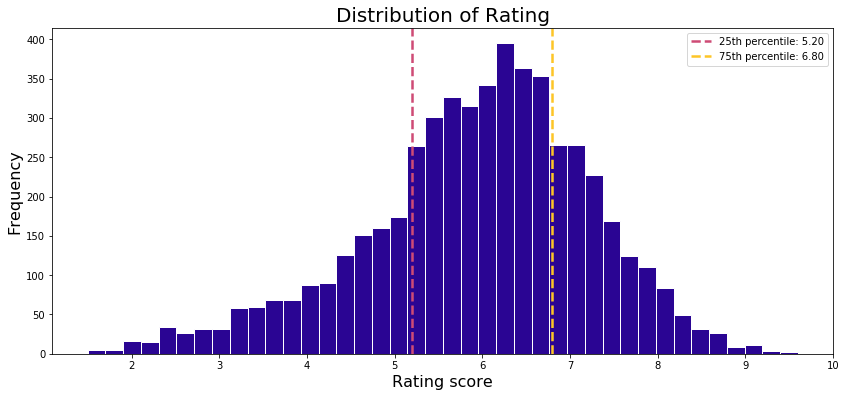

In [15]:
# Plot the histogram using matplotlib
plt.figure(figsize=(14,6))
plt.hist(list(df_movies_ratings['Rating'].values), bins=40, edgecolor='white', color=colorpalette[1])
plt.xlabel('Rating score', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Distribution of Rating', fontsize=20)

# Add vertical lines for mean and median
percentile_25 = np.percentile(list(df_movies_ratings['Rating'].values), 25)
percentile_75 = np.percentile(list(df_movies_ratings['Rating'].values), 75)
plt.axvline(percentile_25, color=colorpalette[20], linestyle="dashed", linewidth=2.5, label=f"25th percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color=colorpalette[35], linestyle="dashed", linewidth=2.5, label=f"75th percentile: {percentile_75:.2f}")
    
# Add a legend
plt.legend()

plt.show()

/Users/jasmink.j.thari/Cinemartist-Networks-and-Interactions-1/Functions.py:480: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)


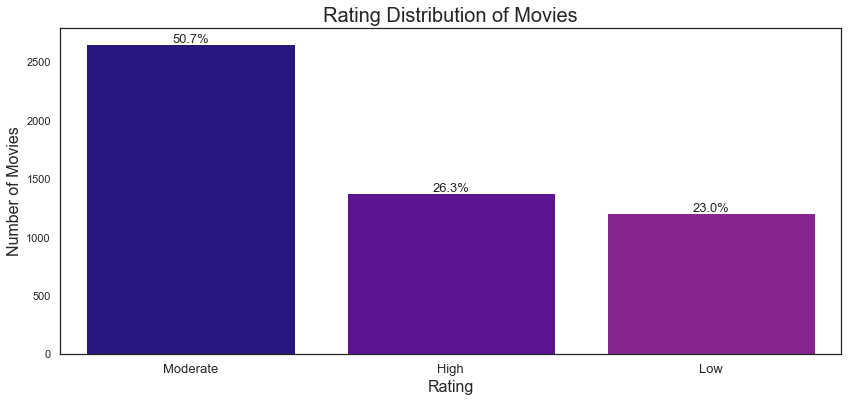

In [16]:
rating_counts = df_movies_ratings['RatingLabel'].value_counts()
rating_counts = rating_counts.reset_index()
rating_counts.columns = ['RatingLabel', 'Count']

plots = Plots()
plots.plot_bar(x = 'RatingLabel', y = 'Count', data = rating_counts, title = 'Rating Distribution of Movies', 
         xlabel= 'Rating', ylabel= 'Number of Movies', figsize=(14,6), 
         color_palette=three_ratings_colors)

### Genre distribution

/Users/jasmink.j.thari/Cinemartist-Networks-and-Interactions-1/Functions.py:480: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)


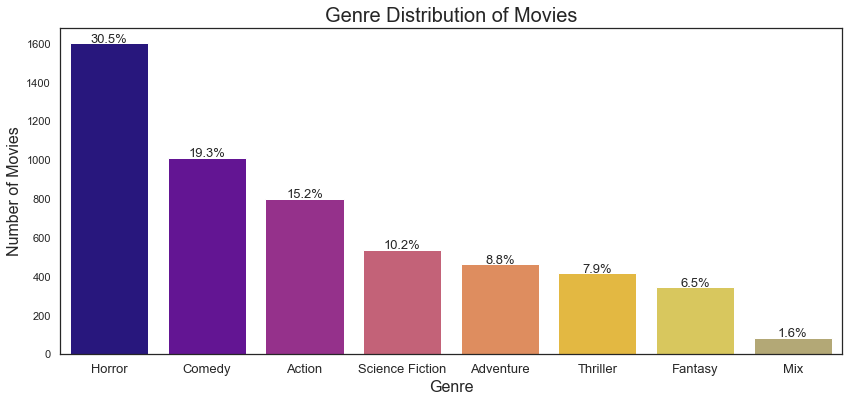

In [17]:
genre_counts = df_movies_ratings['Genre'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Genre', 'Count']
plots = Plots()
plots.plot_bar(x ='Genre', y='Count', data=genre_counts, title='Genre Distribution of Movies', 
         xlabel='Genre', ylabel = 'Number of Movies', figsize=(14,6), color_palette=genre_colors)

### Movies over time 

/Users/jasmink.j.thari/Cinemartist-Networks-and-Interactions-1/Functions.py:480: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)
/Users/jasmink.j.thari/Cinemartist-Networks-and-Interactions-1/Functions.py:480: UserWarning: The palette list has more values (40) than needed (24), which may not be intended.
  barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)


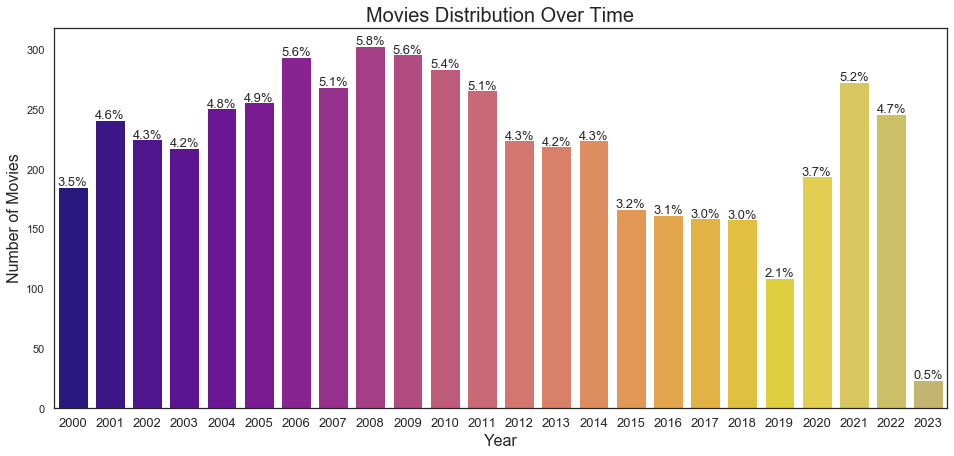

In [18]:
df_movies_ratings['Year'] = pd.to_numeric(df_movies_ratings['Year'], errors='coerce')
movies_per_year = df_movies_ratings.groupby('Year').size()
movies_per_year = movies_per_year.reset_index()
movies_per_year.columns = ['Year', 'Number of Movies']
plots = Plots()
plots.plot_bar(x ='Year', y='Number of Movies', data=movies_per_year, title='Movies Distribution Over Time', 
         xlabel='Year', ylabel = 'Number of Movies', figsize=(16,7), color_palette=colorpalette[::2])

### Country distribution

/Users/jasmink.j.thari/Cinemartist-Networks-and-Interactions-1/Functions.py:480: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)
/Users/jasmink.j.thari/Cinemartist-Networks-and-Interactions-1/Functions.py:480: UserWarning: The palette list has more values (40) than needed (22), which may not be intended.
  barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)


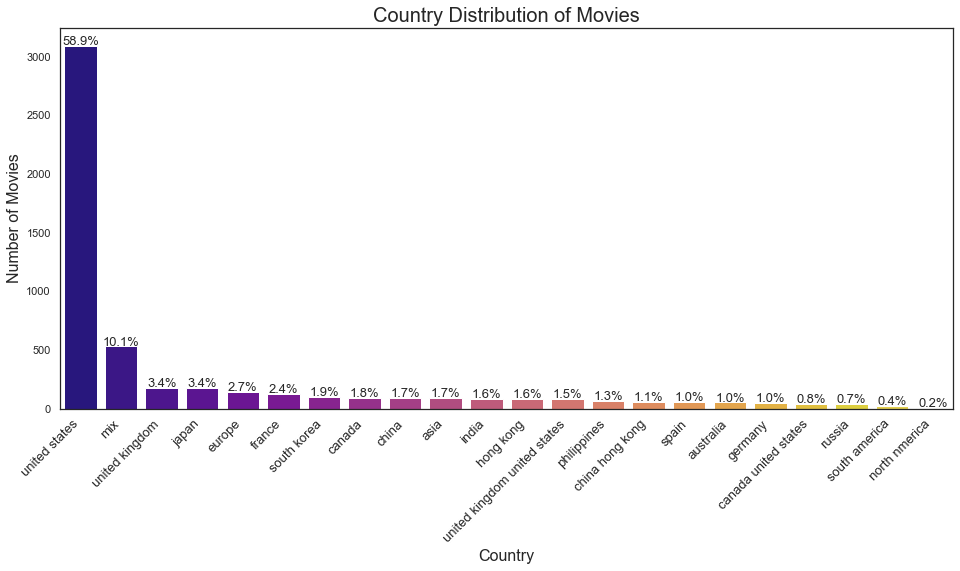

In [19]:
country_counts = df_movies_ratings['Country'].value_counts()
country_counts = country_counts.reset_index()
country_counts.columns = ['Country', 'Count']
plots = Plots()
plots.plot_bar(x ='Country', y='Count', data=country_counts, title='Country Distribution of Movies', 
         xlabel='Country', ylabel = 'Number of Movies', figsize=(16,7), color_palette=colorpalette[::2], rotation=True)



____________


# Network Science

## Get connections between Movies and Artists

In [27]:
# get_connected_movies_artists = GetConnectedMoviesArtist()
# connected_movies = get_connected_movies_artists.connected_movies_and_cast(df_movies_ratings)
# with open('connected_movies_and_artists.json', 'w') as file:
#     json.dump(connected_movies, file, indent=4)


In [28]:
with open('connected_movies_and_artists.json', 'r') as file:
    connected_movies = json.load(file)
len(connected_movies.keys())

5247

## Create Network and add attributes

In [29]:
# Create undirected Graph
G_movies = nx.Graph()

# Adding nodes
movies_nodes = list(connected_movies.keys())
G_movies.add_nodes_from(movies_nodes)

node_attr = df_movies_ratings[['Title','Director','Cast','Country','Genre', 'RatingLabel',
                'Year', 'Decade']].set_index('Title').to_dict('index') # Creating a dictionary with the characters and their attributes

nx.set_node_attributes(G_movies, node_attr) #Adding attributes to the graph

for movie in connected_movies.keys():
    for connected_movie in connected_movies[movie]: 
        weight = len(connected_movies[movie][connected_movie])
        attribute_value = connected_movies[movie][connected_movie]
        G_movies.add_edges_from([(movie, connected_movie)], weight=weight, attribute_name=attribute_value)

In [41]:
for neighbor, edge_attributes in G_movies["365 Days"].items():
    print(f"Edge between and {neighbor}: {edge_attributes}")

Edge between and 365 Days: This Day: {'weight': 3, 'attribute_name': ['michele morrone', 'anna-maria sieklucka', 'magdalena lamparska']}


In [43]:
G_movies.edges["365 Days",'365 Days: This Day']

{'weight': 3,
 'attribute_name': ['michele morrone',
  'anna-maria sieklucka',
  'magdalena lamparska']}

In [32]:
print(G_movies.nodes["365 Days: This Day"])

{'Director': 'barbara biaowas,tomasz mandes', 'Cast': 'anna-maria sieklucka,michele morrone, rebecca casiraghi,magdalena lamparska', 'Country': 'europe', 'Genre': 'Thriller', 'RatingLabel': 'Low', 'Year': 2022, 'Decade': '20-29'}


In [34]:
print("The network consist of: ", G_movies.number_of_nodes(), " nodes (Movies)")
print("The network consist of: ", G_movies.number_of_edges(), " edges")

The network consist of:  5247  nodes (Movies)
The network consist of:  32502  edges


## Get Largest Connected Component

In [44]:
#Extracting the largest component
connected_components = nx.connected_components(G_movies)
# Finding the largest connected component
largest_cc = max(connected_components, key=len)
# Creating a subgraph for the largest connected component
G_largest_cc = G_movies.subgraph(largest_cc).copy()

In [45]:
print("The largest connected component network consist of: ", G_largest_cc.number_of_nodes(), " nodes (Movies)")
print("The largest connected component network consist of: ", G_largest_cc.number_of_edges(), " edges")

The largest connected component network consist of:  3935  nodes (Movies)
The largest connected component network consist of:  32122  edges


In [99]:
# movies_largest_cc contains titles of movies in the largest connected component
movies_largest_cc = list(G_largest_cc.nodes())

# Filter the DataFrame to include only movies in the largest connected component
df_largest_cc = df_movies_ratings[df_movies_ratings['Title'].isin(movies_largest_cc)]

## Plot Network JOJO color after RatingLabels
- if time do also for genre, but not important for now

# Assortativity analysis 

In [37]:
nx.degree_assortativity_coefficient(G_largest_cc)

0.33165829434965627

In [38]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Genre')

0.14106512692317907

In [39]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'RatingLabel')

0.07527119419445817

In [40]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Decade')

0.11485439690433968

### Permutation test of degress

- Shuffling edges while preserving node degrees. This process allows you to assess whether the observed degree assortativity coefficient is significant or could have occurred by random chance.
- Shuffle Edges: Randomly rewire the edges in the network while preserving the degree of each node. This can be done using the nx.double_edge_swap function, which randomly swaps the edges in the graph but keeps the degree sequence the same.
- Compute Assortativity for Each Permutation: Calculate the degree assortativity coefficient for each of these rewired graphs.


In [264]:
original_coefficient = nx.degree_assortativity_coefficient(G_largest_cc)

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

# Make a copy of the original graph for permutation
G_permuted = G_largest_cc.copy()

for _ in range(n_permutations):
    # Perform edge swaps to shuffle the graph while preserving degree sequence
    G_shuffled = nx.double_edge_swap(G_permuted, nswap=10*len(G_permuted.edges()), max_tries=50*len(G_permuted.edges()))

    # Calculate degree assortativity coefficient for the shuffled graph
    coeff = nx.degree_assortativity_coefficient(G_shuffled)
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")


Original Coefficient: 0.33712467636528853
P-Value: 0.0


### Permutation test of Rating

In [262]:
# Assuming G_largest_cc is your original graph
original_coefficient = nx.attribute_assortativity_coefficient(G_largest_cc, 'RatingLabel')

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

for _ in range(n_permutations):
    # Shuffle the Rating attribute among nodes
    G_permu = G_largest_cc.copy()
    genres = [G_permu.nodes[n]['RatingLabel'] for n in G_permu.nodes()]
    np.random.shuffle(genres)
    
    # Assign the shuffled genres back to the nodes
    for n, genre in zip(G_permu.nodes(), genres):
        G_permu.nodes[n]['RatingLabel'] = genre
    
    # Calculate assortativity coefficient for the permuted graph
    coeff = nx.attribute_assortativity_coefficient(G_permu, 'RatingLabel')
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations
# (np.sum([result >= original_coefficient for result in permuted_coefficients]) + 1) / (1000 + 1)

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")

if p_value <= 0.05:
    print(f"significant")
else:
    print(f"There is no significant difference")

Original Coefficient: 0.07406899877737227
P-Value: 0.0
significant


### Permutation test of Genre

In [256]:
# Assuming G_largest_cc is your original graph
original_coefficient = nx.attribute_assortativity_coefficient(G_largest_cc, 'Genre')

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

for _ in range(n_permutations):
    # Shuffle the Genre attribute among nodes
    G_permu = G_largest_cc.copy()
    genres = [G_permu.nodes[n]['Genre'] for n in G_permu.nodes()]
    np.random.shuffle(genres)
    
    # Assign the shuffled genres back to the nodes
    for n, genre in zip(G_permu.nodes(), genres):
        G_permu.nodes[n]['Genre'] = genre
    
    # Calculate assortativity coefficient for the permuted graph
    coeff = nx.attribute_assortativity_coefficient(G_permu, 'Genre')
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations
# (np.sum([result >= original_coefficient for result in permuted_coefficients]) + 1) / (1000 + 1)

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")

if p_value <= 0.05:
    print(f"significant")
else:
    print(f"There is no significant difference")


Original Coefficient: 0.14011725941445055
P-Value: 0.0


### Permutation test of Decade

In [263]:
original_coefficient = nx.attribute_assortativity_coefficient(G_largest_cc, 'Decade')

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

for _ in range(n_permutations):
    # Shuffle the Year attribute among nodes
    G_permu = G_largest_cc.copy()
    genres = [G_permu.nodes[n]['Decade'] for n in G_permu.nodes()]
    np.random.shuffle(genres)
    
    # Assign the shuffled genres back to the nodes
    for n, genre in zip(G_permu.nodes(), genres):
        G_permu.nodes[n]['Decade'] = genre
    
    # Calculate assortativity coefficient for the permuted graph
    coeff = nx.attribute_assortativity_coefficient(G_permu, 'Decade')
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations
# (np.sum([result >= original_coefficient for result in permuted_coefficients]) + 1) / (1000 + 1)

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")

if p_value <= 0.05:
    print(f"significant")
else:
    print(f"There is no significant difference")


Original Coefficient: 0.11670078205832192
P-Value: 0.0
significant


# Communities 

In [79]:
#Set seed
seed = 42

# computing best community partition
partition = community.best_partition(G_largest_cc)

# Get a set of the communities
communities = set(partition.values())

In [83]:
#Number of communities (+1 because community "0" also exist)
print('Number of communities:', max(partition.values())+1)

Number of communities: 31


/Users/jasmink.j.thari/Cinemartist-Networks-and-Interactions-1/Functions.py:480: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)
/Users/jasmink.j.thari/Cinemartist-Networks-and-Interactions-1/Functions.py:480: UserWarning: The palette list has more values (40) than needed (31), which may not be intended.
  barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)


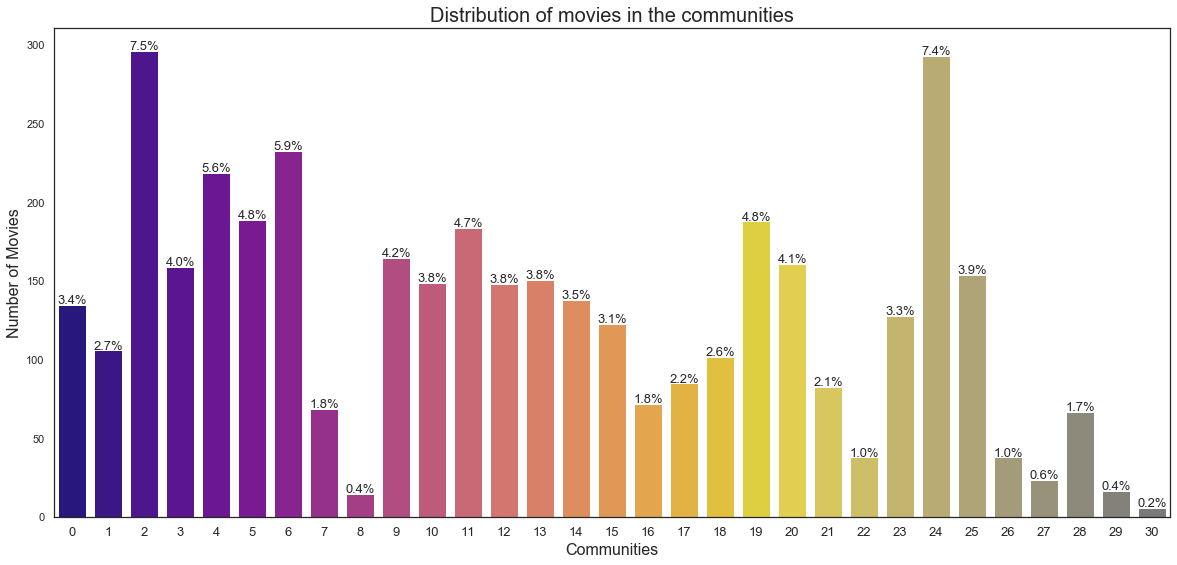

In [90]:
community_count = pd.DataFrame(data={'Communities':list(partition.values())}).value_counts()
community_count = community_count.reset_index()
community_count.columns = ['Communities', 'Count'] 
plots = Plots()
plots.plot_bar(x ='Communities', y='Count', data=community_count, title='Distribution of movies in the communities', 
         xlabel='Communities', ylabel = 'Number of Movies', figsize=(20,9), color_palette=colorpalette[::2])


In [88]:
modularity = community.modularity(partition, G_largest_cc)
print('Modularity of Network:', round(modularity,2))

Modularity of Network: 0.55


### Analysis 

- The communities are renamed after the 3 nodes within each of them with the highest degree. This will make interpretation of the communities much easier.


In [100]:
#Rename communities
#Find largest degree nodes in each com.
communities_dict = {c: [k for k, v in partition.items() if v == c] for c in communities}
highest_degree = {k: heapq.nlargest(3, v, key=lambda x: G_largest_cc.degree(x)) for k, v in communities_dict.items()}

#Add column to community dataframe with community names
for key, values in highest_degree.items():
    df_largest_cc.loc[df_largest_cc.community == key, 'com_name'] = ", ".join(values).replace('_',' ') 

/Users/jasmink.j.thari/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [106]:
name_com = df_largest_cc['com_name'].value_counts()
name_com = name_com.reset_index()
name_com.columns = ['Community Name', 'Count']
print(tabulate(name_com, headers='keys', tablefmt='pretty'))

+----+-----------------------------------------------------------------------------------------------------+-------+
|    |                                           Community Name                                            | Count |
+----+-----------------------------------------------------------------------------------------------------+-------+
| 0  |                      Triple Threat, SPL II: A Time for Consequences, Day Shift                      |  296  |
| 1  |                     Chillerama, Justice League Dark: Apokolips War, Blood Rayne                     |  293  |
| 2  |                       Clash of the Titans, Wrath of the Titans, Batman Begins                       |  233  |
| 3  |                     Amsterdam, Thor: Love and Thunder, Guardians of the Galaxy                      |  219  |
| 4  |                                Dolittle, Hairspray, Shrek the Third                                 |  189  |
| 5  |           Minions: The Rise of Gru, I Now Pronounce You C

In [108]:
rating_counts = df_largest_cc.groupby('com_name')['RatingLabel'].value_counts().unstack(fill_value=0)
rating_counts_reset = rating_counts.reset_index()
print(tabulate(rating_counts_reset, headers='keys', tablefmt='pretty'))


+----+-----------------------------------------------------------------------------------------------------+------+-----+----------+
|    |                                              com_name                                               | High | Low | Moderate |
+----+-----------------------------------------------------------------------------------------------------+------+-----+----------+
| 0  |                       A Perfect Getaway, Resident Evil: Apocalypse, Survivor                        |  29  | 44  |    81    |
| 1  |                                     Alexander, The Batman, Epic                                     |  42  | 21  |    43    |
| 2  |                     Amsterdam, Thor: Love and Thunder, Guardians of the Galaxy                      |  62  | 28  |   129    |
| 3  | Beauty and the Beast bill condon, The Hobbit: The Battle of the Five Armies, The Island michael bay |  67  | 17  |    64    |
| 4  |                     Chillerama, Justice League Dark: Apokolips

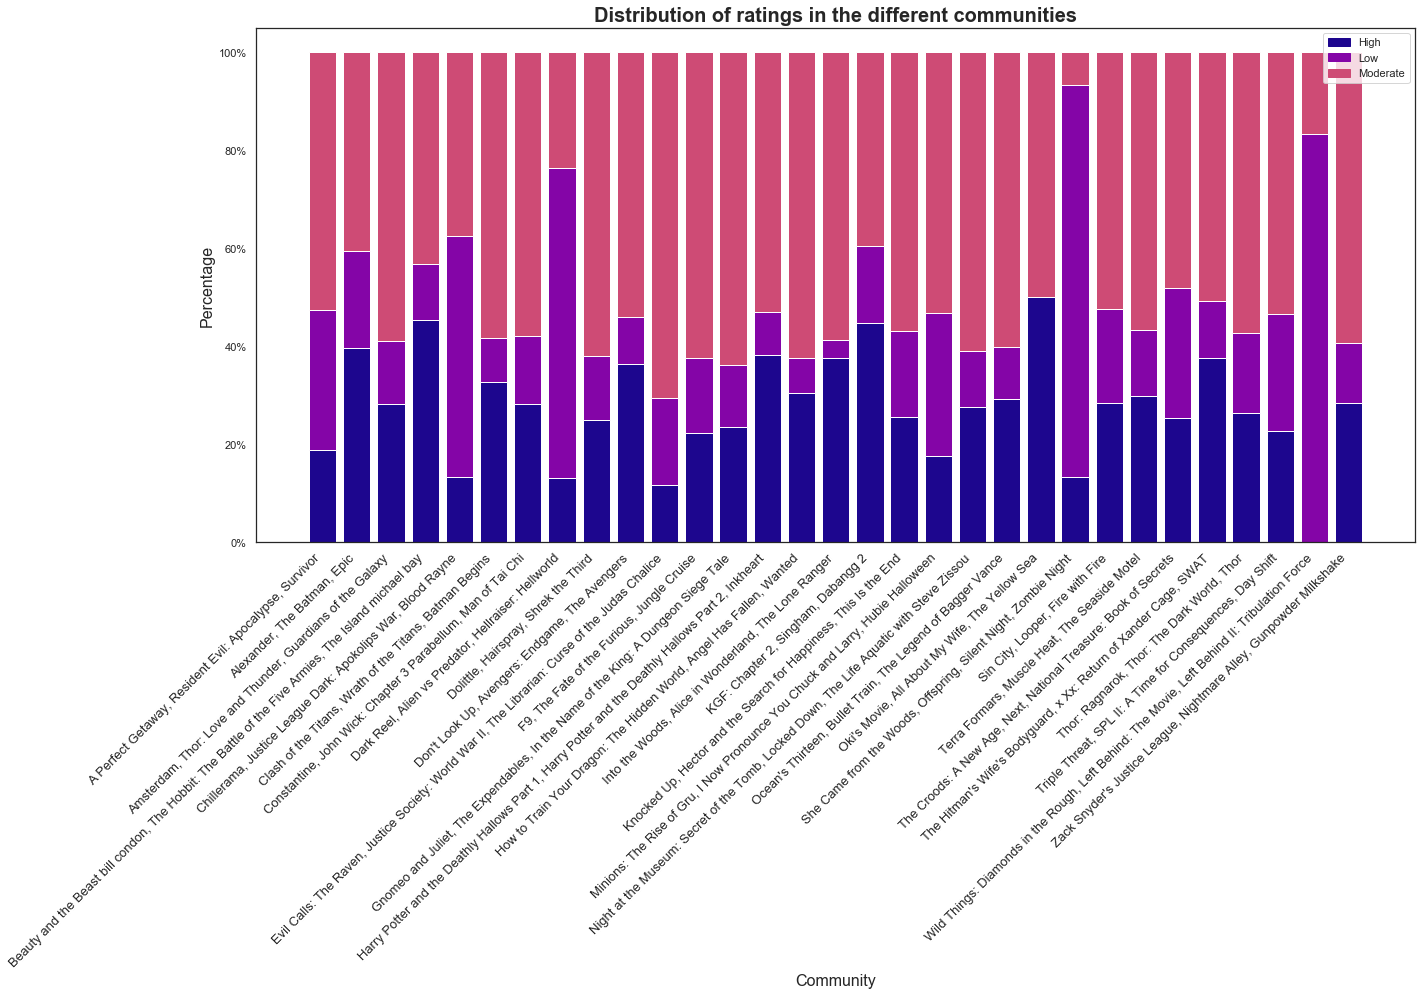

In [198]:
# Set the ratings
ratings = ['High', 'Low', 'Moderate']

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(20, 14))

# Initialize legend handles and labels
legend_handles = []
legend_labels = []

# Iterate through each row in the DataFrame
for index, row in rating_counts_reset.iterrows():
    com_name = row['com_name']
    
    # Get the rating counts for the current com_name
    rating_counts = [row[rating] for rating in ratings]
    
    # Calculate the total count for normalization
    total_count = sum(rating_counts)
    
    # Convert counts to percentages
    rating_percentages = [count / total_count * 100 for count in rating_counts]
    
    # Create a vertical stacked bar for the current com_name
    bars = ax.bar(com_name, height=rating_percentages, color=three_different_colors, bottom=[sum(rating_percentages[:i]) for i in range(len(ratings))])
    
    # Create legend handles and labels for each rating
    for i, rating in enumerate(ratings):
        if index == 0:
            legend_handles.append(mpatches.Patch(color=three_different_colors[i], label=rating))
    
# Manually create the legend without count numbers
ax.legend(handles=legend_handles)

# Set the y-axis label
ax.set_ylabel('Percentage', fontsize=16)
ax.set_xlabel('Community', fontsize=16)

# Set the y-axis ticks to display percentages
ax.set_yticklabels(['{:,.0f}%'.format(x) for x in ax.get_yticks()])

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right',  fontsize=13)

# Set the plot title
plt.title("Distribution of ratings in the different communities",  fontsize=20, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


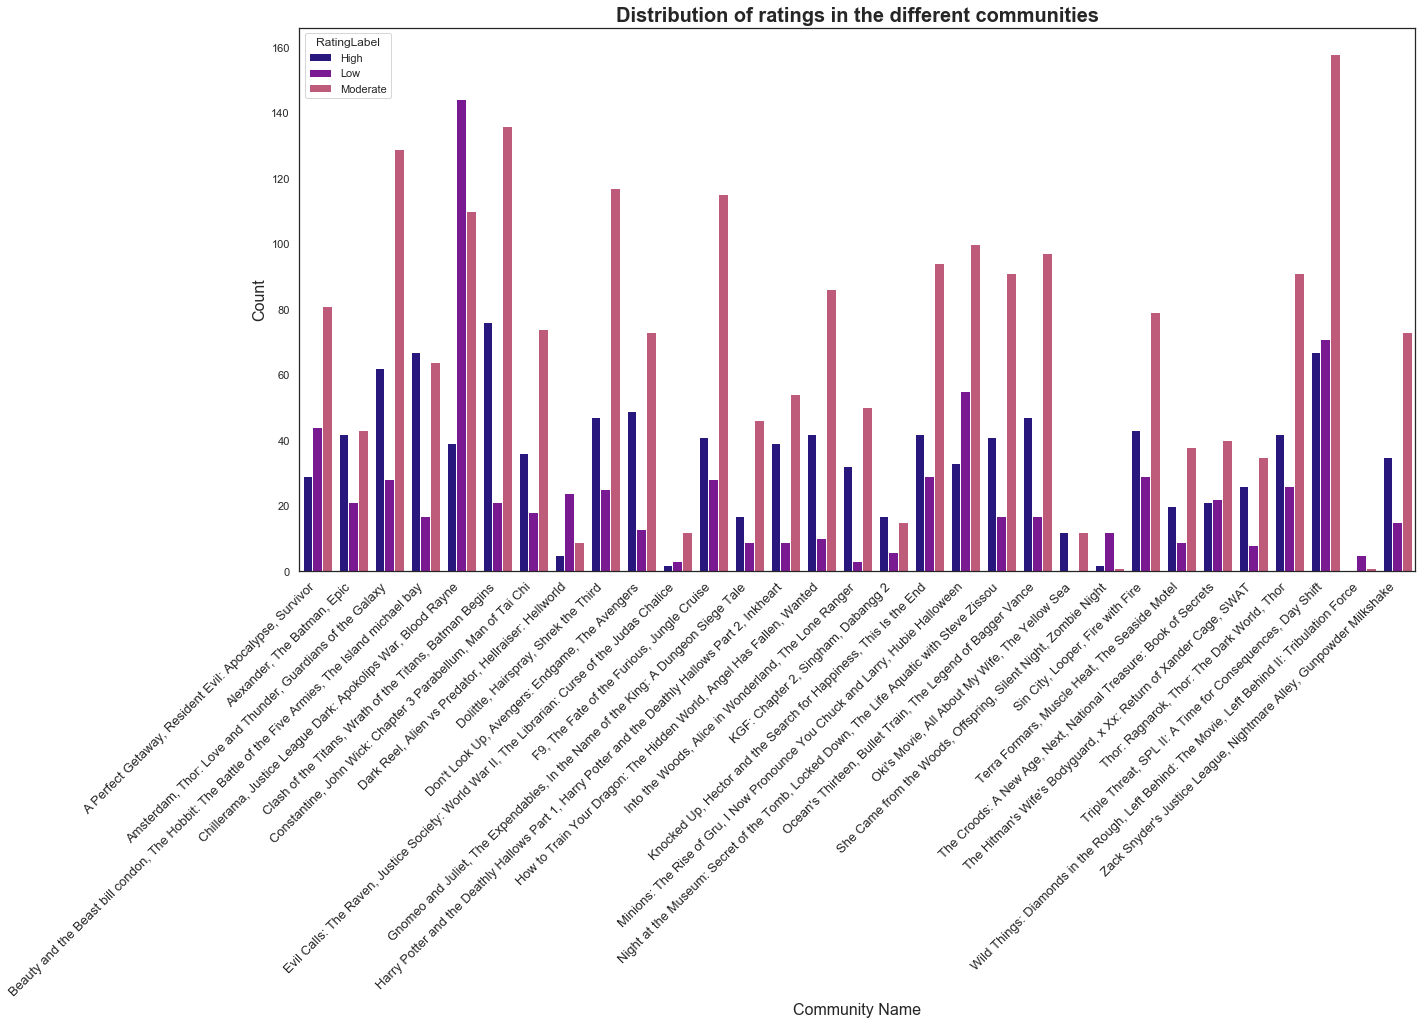

In [154]:
# Melting the DataFrame if needed
rating_counts_melted = rating_counts_reset.melt(id_vars='com_name', var_name='RatingLabel', value_name='Count')

sns.set(style="white")
plt.figure(figsize=(20, 10))
barplot = sns.barplot(x='com_name', y='Count', hue='RatingLabel', data=rating_counts_melted, palette=three_different_colors)


title = "Distribution of ratings in the different communities"
xlabel = "Community Name"
ylabel = "Count"

# Rotate the labels on x-axis for better readability
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.title(title, fontsize=20, fontweight="bold")
plt.xlabel(xlabel, fontsize=16)
plt.ylabel(ylabel, fontsize=16)
plt.show()


In [109]:
genre_counts = df_largest_cc.groupby('com_name')['Genre'].value_counts().unstack(fill_value=0)
genre_counts_reset = genre_counts.reset_index()
print(tabulate(genre_counts_reset, headers='keys', tablefmt='pretty'))

+----+-----------------------------------------------------------------------------------------------------+--------+-----------+--------+---------+--------+-----+-----------------+----------+
|    |                                              com_name                                               | Action | Adventure | Comedy | Fantasy | Horror | Mix | Science Fiction | Thriller |
+----+-----------------------------------------------------------------------------------------------------+--------+-----------+--------+---------+--------+-----+-----------------+----------+
| 0  |                       A Perfect Getaway, Resident Evil: Apocalypse, Survivor                        |   15   |    15     |   43   |    6    |   47   |  2  |       14        |    12    |
| 1  |                                     Alexander, The Batman, Epic                                     |   23   |    11     |   12   |    8    |   24   |  1  |       12        |    15    |
| 2  |                     Amsterda

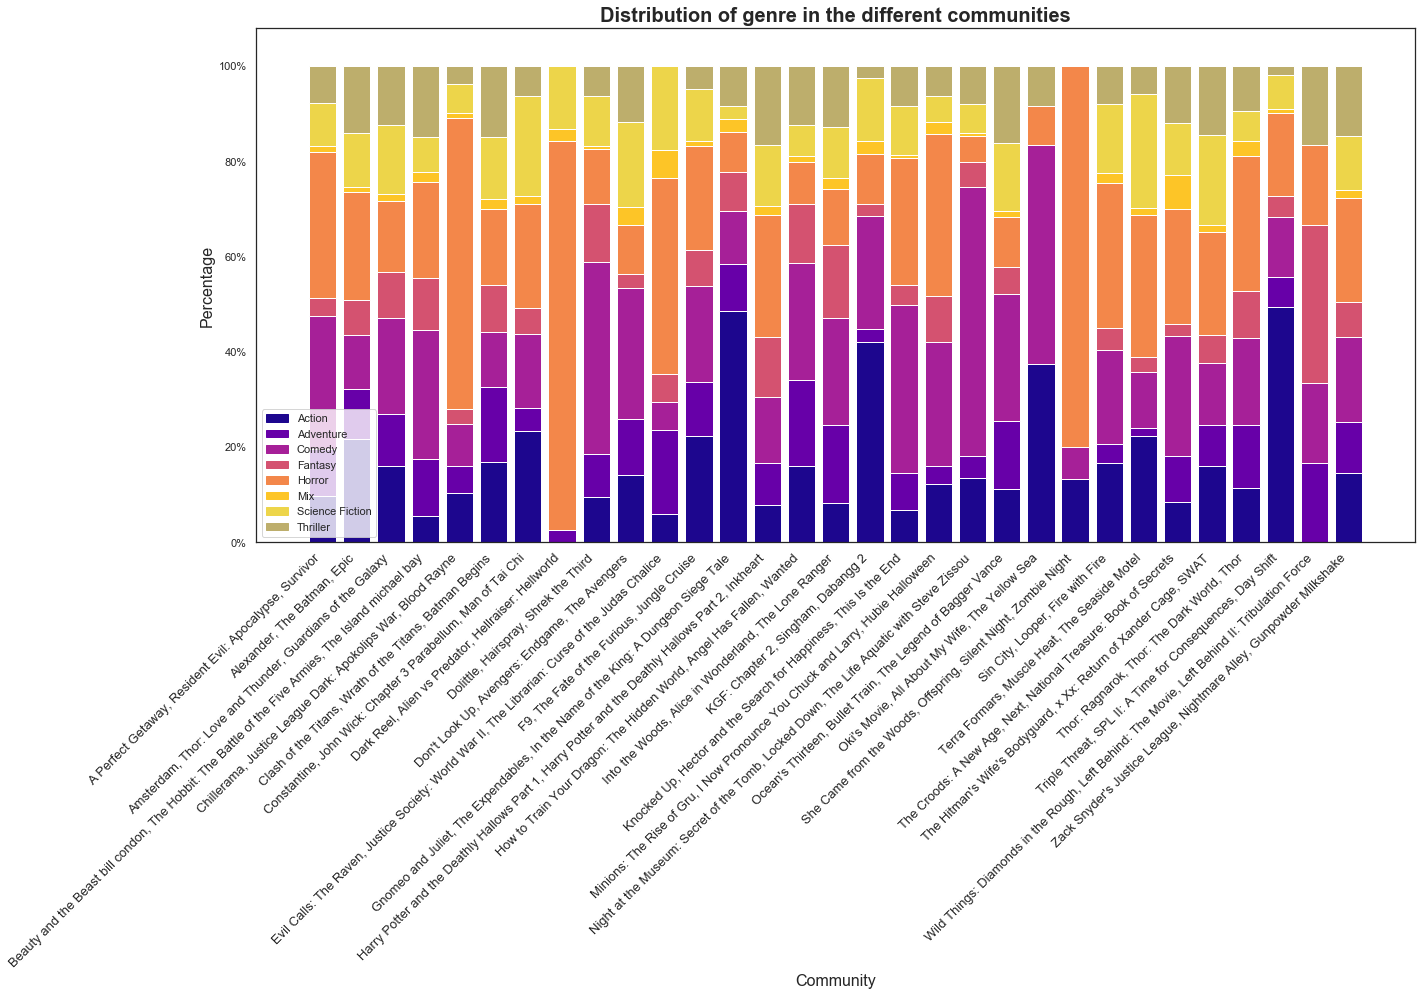

In [228]:
# Set the ratings
genres = ['Action','Adventure','Comedy','Fantasy','Horror','Mix','Science Fiction','Thriller']

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(20, 14))

# Initialize legend handles and labels
legend_handles = []
legend_labels = []

# Iterate through each row in the DataFrame
for index, row in genre_counts_reset.iterrows():
    com_name = row['com_name']
    
    # Get the rating counts for the current com_name
    genre_counts = [row[genre] for genre in genres]
    
    # Calculate the total count for normalization
    total_count = sum(genre_counts)
    
    # Convert counts to percentages
    genre_percentages = [count / total_count * 100 for count in genre_counts]
    
    # Create a vertical stacked bar for the current com_name
    bars = ax.bar(com_name, height=genre_percentages, color=genre_colors, bottom=[sum(genre_percentages[:i]) for i in range(len(genres))])
    
    # Create legend handles and labels for each rating
    for i, genre in enumerate(genres):
        if index == 0:
            legend_handles.append(mpatches.Patch(color=genre_colors[i], label=genre))
    
# Manually create the legend without count numbers
ax.legend(handles=legend_handles)

# Set the y-axis label
ax.set_ylabel('Percentage', fontsize=16)
ax.set_xlabel('Community', fontsize=16)

# Set the y-axis ticks to display percentages
ax.set_yticklabels(['{:,.0f}%'.format(x) for x in ax.get_yticks()])
ax.set_ylim([0, ax.get_ylim()[1] * 1.08]) 
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right',  fontsize=13)

# Set the plot title
plt.title("Distribution of genre in the different communities",  fontsize=20, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


In [134]:
df_largest_cc['Casts'] = df_largest_cc['Cast'].str.split(',')
df_cast_expanded = df_largest_cc.explode('Casts')
df_cast_expanded['Casts'] = df_cast_expanded['Casts'].str.strip()

cast_counts = df_cast_expanded.groupby(['com_name', 'Casts']).size().reset_index(name='count')
# Rank cast members within each community
cast_counts['rank'] = cast_counts.groupby('com_name')['count'].rank(method='first', ascending=False)

# Filter to keep only top 10 casts in each community
top_casts = cast_counts[cast_counts['rank'] <= 10]

# Pivot the table
pivot_table = top_casts.pivot(index='com_name', columns='rank', values=['Casts', 'count'])

# Flatten the multi-level column headers
pivot_table.columns = [' '.join(map(str, col)).strip() for col in pivot_table.columns.values]
for i in range(1, 11):  # Adjust the range according to the number of top casts you have
    cast_col = f"Casts {float(i)}"
    count_col = f"count {float(i)}"

    if cast_col in pivot_table.columns and count_col in pivot_table.columns:
        pivot_table[cast_col] = pivot_table[cast_col].astype(str) + ", " + pivot_table[count_col].astype(str)
        pivot_table.drop([count_col], axis=1, inplace=True)



pivot_table_reset = pivot_table.reset_index()

# Print the table
print(tabulate(pivot_table_reset, headers='keys', tablefmt='pretty'))


+----+-----------------------------------------------------------------------------------------------------+------------------------+---------------------+---------------------------+----------------------+--------------------------+-------------------------+---------------------+---------------------+-------------------------+-----------------------+
|    |                                              com_name                                               |       Casts 1.0        |      Casts 2.0      |         Casts 3.0         |      Casts 4.0       |        Casts 5.0         |        Casts 6.0        |      Casts 7.0      |      Casts 8.0      |        Casts 9.0        |      Casts 10.0       |
+----+-----------------------------------------------------------------------------------------------------+------------------------+---------------------+---------------------------+----------------------+--------------------------+-------------------------+---------------------+-----------